# Everything You Ever Needed to Know About Linear Regression

This notebook is here to answer all the questions you've ever had about linear regression. I'll walk you through every step of the process, from acquiring data, describing it, creating a model, evaluating it, optimizing it, and preventing it from overfitting. Along the way I'll introduce generally applicable data science techniques like data munging, visualizations, and some nifty Python code. I take a two-pronged approach to introducing linear regression: code and math. Every problem I present in this notebook can be described from an abstract, mathematical perspective as well as concretely in code. Both of these perspectives are important, and shed light on different aspects of linear regression, so I do a careful dance back and forth between both of these. At the end of this notebook, you'll have a deep understanding of linear regression. If you're a beginner, you'll find yourself comfortable. And if you've already encountered linear regression before, you'll leave with all of your nagging questions answered.

Before reading this you should have a basic understanding of coding principles. All the code in this notebook is in Python, but if you know another high-level language it should be easy to follow along even if you've never written a single line of Python before. I also use Python's matplotlib and pandas libraries frequently, and it'll be worth your while to check out their documentation if you find yourself getting lost. I also introduce some mathematical formalisms from calculus and linear algebra. However, I explain these topics in such a way that they will make sense to people who've never taken a calculus class before.

Although linear regression is often introduced in a formal, statistical way, I'm going to talk about the topic from a less formal, more machine-learly perspective. This doesn't mean that I'm any less rigorous, but that the rigour comes from the practical perspective of a data scientist rather than the theoretical persective of a mathematician. Hold onto your seats and enjoy the ride!

## Data Acquisition
Before we can start, let's find some data we might care about. A _linear_ model is used to model _linear_ relationships in a dataset, so I'm going to download [a dataset from kaggle](https://www.kaggle.com/mustafaali96/weight-height) that I expect to be linear: a collection of people's height, weight, and gender (I'll throw away the gender information). Non-linear data might be something like temperature as a function of time: temperature rises and falls throughout the day, taking the shape of a sine wave.

Let's start off by loading up [pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/tutorials.html) and [matplotlib](https://matplotlib.org/3.1.1/tutorials/index.html). These libraries will let us easily manipulate our data for analysis purposes.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_1 = pd.read_csv("../data/weight-height.csv")
df_1.head(5)

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [3]:
# Let's make things simpler by using only the Males and then throwing away the gender info.
df_1 = df_1.loc[df_1.Gender == "Male"]
df_1 = df_1.drop("Gender", axis=1)
df_1.head(5)

,Height,Weight
0,73.847017,241.893563
1,68.781904,162.310473
2,74.110105,212.740856
3,71.730978,220.042470
4,69.881796,206.349801


## Data Visualization
Now let's plot the data to see what it looks like. If the data appears to fall on a line, then it's linear and we can use a linear model to describe it.

Hint: if data takes the shape of a crooked line (it's exponential), we can manipulate the scale of our axes, such as using a logarithmic transform, to make the data look like a stright line. Read more about that [here](https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/06LeastSquares/transformations/complete.html).

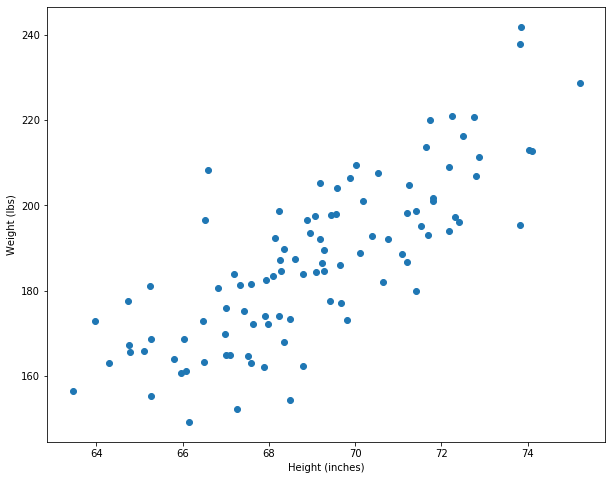

In [4]:
# Create a plotting function that we will re-use in future graphs.

def set_plot_1():
    # Set the figure size and axis.
    plt.rcParams['figure.figsize'] = [10, 8]
    plt.xlabel("Height (inches)")
    plt.ylabel("Weight (lbs)")
    
    # Plot the first 100 points from the dataset.
    plt.scatter(df_1["Height"][:100], df_1["Weight"][:100])
    
set_plot_1()

Great! This data looks approximately linear. As someone's _height_ goes up, so does their _weight_ -- and this totally makes sense. When two variables change such that when one gets larger the other one also gets larger, we call that a _positive correlation_. When one variable gets bigger and another gets smaller, that's called _negative corrlelation_. These variables are positively correlated and linear.

## Simple Modeling

Now it's time to put our data science hat on... what if we happened to have some new data on hand, but this data only contained information about people's _heights_. If we only knew height information, would we be able to predict a person's weight? The answer is yes! We could imagine drawing a line through the middle of our data, like below. If we know someone's height (from the _x-axis_) we can choose the value on the _y-axis_ (weight) that it corresponds to.

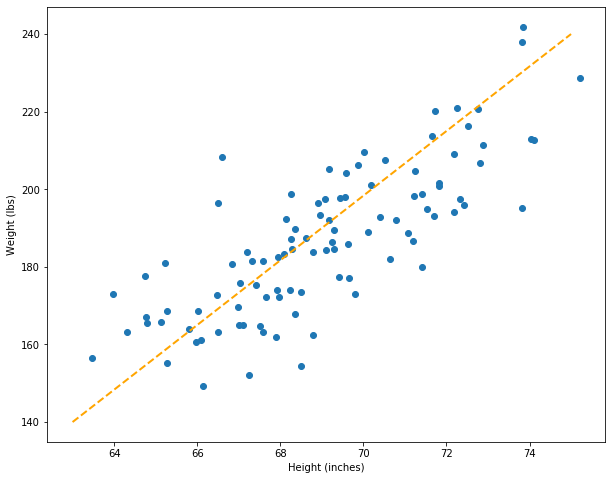

In [5]:
set_plot_1()

# Add a prediction line.
plt.plot([63, 75], [140, 240], color='orange', linestyle='dashed', linewidth=2, markersize=12, label="guess model")

With this model, we can make simple predictions. However, how do we know if this model is a good model? Furthermore, how can we tell whether it's better than other models we could create? This model was created by simply drawing a line through two pairs of points: `[63, 140], [75, 240]`, (above).

## Simple Math

While drawing a line through our dots might suffice for some purposes, we want to translate the problem of finding a good line to the domain of mathemetics. We can start off by reformulating the question in terms of the equation of the line, which is something that everyone learned in Middle School math class but subsequently forgot: 

$$ y = mx + b $$

This equation tells us that we can get the value for _y_ (which in our case is _weight_) by plugging in the value for _x_ (_height_) then multiplying it by some unknown value _m_ and adding it to another unknown value _b_. These unknown values are called the _parameters_ of our model, and our model is _the equation of a line_. Graphically, the value _m_ corresponds to the slope of the line, and _b_ corresponds to where the line intercepts the _y-axis_ (in other words, _b_ is the value of _y_ when _x_ is _0_).

This is a good approach to the problem of creating a model, because it changes the problem from one where we guess two pairs of points and draw a line through them, to one where we instead create a function that can accept **any** x-value and generate its corresponding y-value.

Let's apply this to our current challenge of predicting weight from height. In the cells below, I'll erase the weight data from our dataset. Then I'll reconstruct the weight data using the equation of the line, but with values for _m_ and _b_ that I guessed.

__Note:__ While _m_ corresponds to the slope of the line on a graph and _b_ corresponds to its y-intercept, it's not necessary to always think of these values as how they relate to a graph: we can also think of them more abstractly, as quantities that effect the error of the line (next section).

In [6]:
def linear_function(x, m, b):
    """
    This function accepts an x-value and two parameter values, m and b. These values
    are the parameters of the equation of the line, which (on a graph) correspond to
    the slope of the line and the y-intercept, respectively.
    """
    
    return m * x + b

# Test Example
assert linear_function(60, m=0.6, b=140) == 176.0

To draw a new prediction line, I'll simple take two x-values -- one close to the height of the shortest person and another close to the height of the tallest person, and generate the predicted y-values. Then I can use this pair of points to generate a prediction line.

In [7]:
# Height values close to the end-points of our distribution.
min_x, max_x = 64, 74

# Predict the weights based on the heights by using the `predict_weight` function.
pred_y_min = linear_function(min_x, m=0.6, b=140)
pred_y_max = linear_function(max_x, m=0.6, b=140)

# Generate the points that we will plot.
x1 = [min_x, max_x]
y1 = [pred_y_min, pred_y_max]

x1, y1

([64, 74], [178.4, 184.4])

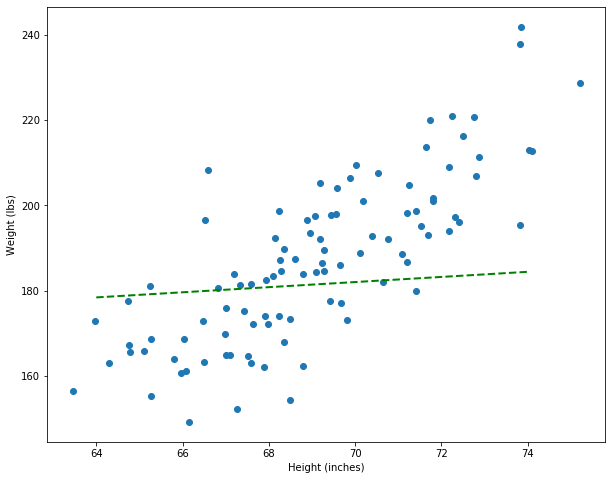

In [8]:
set_plot_1()

# Add a prediction line. Notice that x1 and x1 are used instead of the "guesses" I made before.
plt.plot(x1, y1, color='green', linestyle='dashed', linewidth=2, markersize=12, label="bad model")

Wow, this model is really bad! It's way worse than the orange line where I "guessed" beforehand. However, having translated model into the equation of a line lets us think about the problem mathematically. In fact, we can now create a metric that tells us which lines are better or worse as models. The model that produced the green line is a linear model defined by its parameters, which I set as `m=0.6, b=140`. I'm going to create another model and plot it as well.

In [9]:
# The predicted values come from a new model: notice the new parameters, 3.5 and -50.
pred_y_min = linear_function(min_x, 3.5, -50)
pred_y_max = linear_function(max_x, 3.5, -50)

# Generate the points that we will plot.
x2 = [min_x, max_x]
y2 = [pred_y_min, pred_y_max]

x2, y2

([64, 74], [174.0, 209.0])

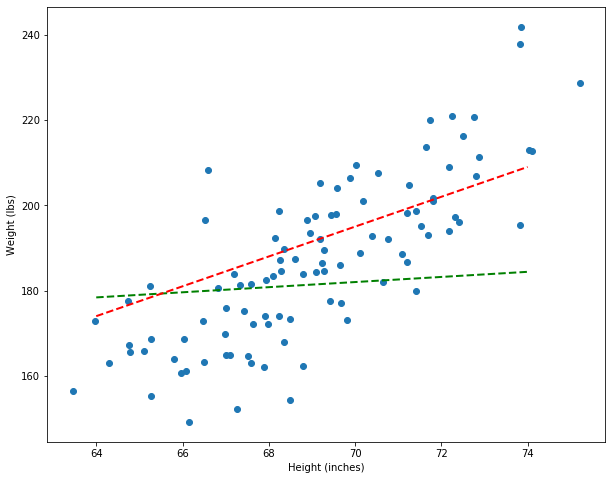

In [10]:
set_plot_1()

# Add prediction lines for each of the models.
plt.plot(x1, y1, color='green', linestyle='dashed', linewidth=2, markersize=12, label="bad model")
plt.plot(x2, y2, color='red', linestyle='dashed', linewidth=2, markersize=12, label="better model")

Notice that the new model, which is represented by the red line, is a better model than the green line. But how can we prove, mathematically, that the red line is better instead of just eye-balling it? In the next section, I'll show you how to do exactly that!

## Visually Measuring Error

In the last section, I showed how we can use the equation of a line to generate predicted y-values (weights) based on some x-values (heights). In this context, the equation of a line is a function that accepts _x-values_ and outputs _y-values_. And because this is machine learning and we're making predictions, this function is called a _model_. 

In this section I'll show how we can compare different models in terms of their residuals. I'll visually define what a model's residuals look like, and in the next section I'll introduce some math to quantify it.

Let's say that we have a model that creates a line of predictions like below. The error of the model is the difference between the predicted y-value (the line) and the actual y-value (the dot):

In [11]:
# Choose a random point and get its x and y coordinates.
pt_x, pt_y = df_1["Height"][4], df_1["Weight"][4]

# Get the predicted y-value for the x-value.
y_pred = float(linear_function(pt_x, 3.5, -50))

# Calculate the residual.
residual = float(pt_y - y_pred)

print(f"The predicted y-value is {y_pred:.2f}, but the actual value is {float(pt_y):.2f}. The difference between these two values, called the residual, is {residual:.2f}")


The predicted y-value is 194.59, but the actual value is 206.35. The difference between these two values, called the residual, is 11.76


The two pairs of points, _(x, y), (x, y_pred)_ can be plotted as a blue line, shown below. Longer blue lines correspond to larger residuals. And models that have greater total residuals are worse models!

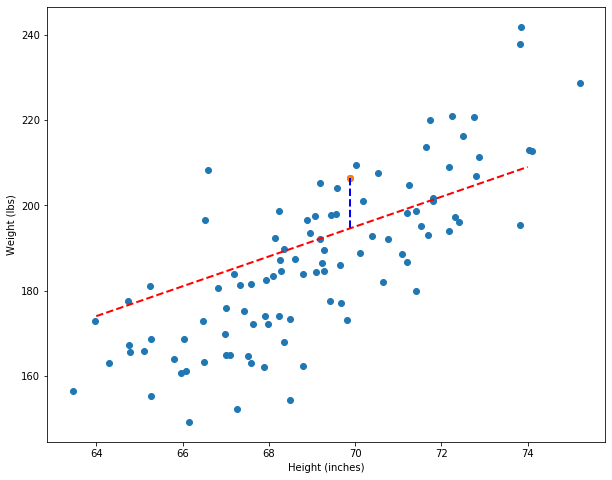

In [12]:
set_plot_1()

# Show only one point.
plt.scatter(pt_x, pt_y)

# Add a prediction line.
plt.plot(x2, y2, color='red', linestyle='dashed', linewidth=2, markersize=12, label="better model")

# Add the residual: the line that shows the difference between the data and the model.
plt.plot([float(pt_x), float(pt_x)], [float(pt_y), float(pt_y) - residual], color='blue', linestyle='dashed', linewidth=2, markersize=12, label="bad model_2")


To demonstrate even more explicitly how the residuals can show which model is better, I'm going to plot both the bad (green) and decent (red) models side-by-side and show what some of their residuals look like. Notice that the total vertical distances between the green line and the points is much greater than between the red line and the points.

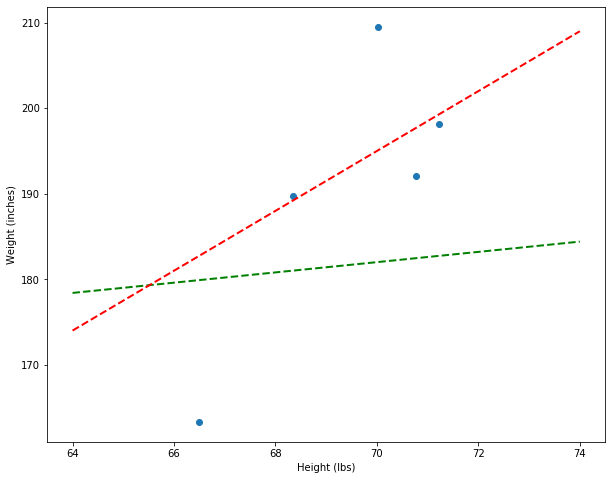

In [13]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.xlabel("Height (lbs)")
plt.ylabel("Weight (inches)")

# Show some random points.
pts_x, pts_y = df_1["Height"][55:60], df_1["Weight"][55:60]
plt.scatter(pts_x, pts_y)

# Add models.
plt.plot(x1, y1, color='green', linestyle='dashed', linewidth=2, markersize=12, label="better model")
plt.plot(x2, y2, color='red', linestyle='dashed', linewidth=2, markersize=12, label="bad model")

## Sum of Squared Errors

In the last section I showed how the residuals can be used _visually_ to show the error of a model. In this section I'll translate this visual intuition into math.

Let's start off by generating predictions for all the points in our dataset. These predictions will be a new column in the dataset.

In [14]:
df_1.head(5)

,Height,Weight
0,73.847017,241.893563
1,68.781904,162.310473
2,74.110105,212.740856
3,71.730978,220.042470
4,69.881796,206.349801


In [15]:
# Predict the weight for every height in our dataset.
pred_weights_model_1 = [linear_function(x, 0.6, 140) for x in df_1["Height"]]
pred_weights_model_2 = [linear_function(x, 3.5, -50) for x in df_1["Height"]]

# Add this as a column to the dataset.
df_1["Weight_Pred_Model_1"] = pred_weights_model_1
df_1["Weight_Pred_Model_2"] = pred_weights_model_2

df_1.head(5)

,Height,Weight,Weight_Pred_Model_1,Weight_Pred_Model_2
0,73.847017,241.893563,184.308210,208.464560
1,68.781904,162.310473,181.269142,190.736664
2,74.110105,212.740856,184.466063,209.385369
3,71.730978,220.042470,183.038587,201.058424
4,69.881796,206.349801,181.929078,194.586286


In [16]:
# Add another column with the residuals.
df_1["Model_1_Residual"] = df_1["Weight"] - df_1["Weight_Pred_Model_1"]
df_1["Model_2_Residual"] = df_1["Weight"] - df_1["Weight_Pred_Model_2"]

df_1.head(5)

,Height,Weight,Weight_Pred_Model_1,Weight_Pred_Model_2,Model_1_Residual,Model_2_Residual
0,73.847017,241.893563,184.308210,208.464560,57.585353,33.429004
1,68.781904,162.310473,181.269142,190.736664,-18.958670,-28.426192
2,74.110105,212.740856,184.466063,209.385369,28.274792,3.355487
3,71.730978,220.042470,183.038587,201.058424,37.003883,18.984046
4,69.881796,206.349801,181.929078,194.586286,24.420723,11.763515


Now we arrive at an important question -- how do we use all of the residuals to determine which model is better? We know from the start that model 2 (red) is better than model 1 (green). We also know that some residuals are positive and some are negative... so they might cancel out. One strategy might be to convert all the residuals to positive and then add them up. In other words, we take the absolute value of each residual and then sum them. If this works as intended, the sum should be greater for the `Model_1_Residual` (the bad model) column than for the `Model_2_Residual` (better model) column.

In [17]:
# Apply the absolute value function so that the positive and negative errors don't cancel out!
df_1["Model_1_Residual"] = [abs(x) for x in df_1["Model_1_Residual"]]
df_1["Model_2_Residual"] = [abs(x) for x in df_1["Model_2_Residual"]]

df_1.head(5)

,Height,Weight,Weight_Pred_Model_1,Weight_Pred_Model_2,Model_1_Residual,Model_2_Residual
0,73.847017,241.893563,184.308210,208.464560,57.585353,33.429004
1,68.781904,162.310473,181.269142,190.736664,18.958670,28.426192
2,74.110105,212.740856,184.466063,209.385369,28.274792,3.355487
3,71.730978,220.042470,183.038587,201.058424,37.003883,18.984046
4,69.881796,206.349801,181.929078,194.586286,24.420723,11.763515


In [18]:
res_1, res_2 = sum(df_1["Model_1_Residual"]), sum(df_1["Model_2_Residual"])

print(f"The total error for Model 1 is {res_1:.2f} and the total error for Model 2 is {res_2:.2f}.")

The total error for Model 1 is 76427.75 and the total error for Model 2 is 52213.22.


This error function seems to do the job! However, in the natural sciences, rather than taking the sum of absolute value errors, we usually take the sum of squared errors. Let's do that right now (also, keep in mind that the result of squaring a number is always positive, so I don't need to un-absolute value the data).

In [19]:
df_1["Model_1_Residual_Sq"] = [x**2 for x in df_1["Model_1_Residual"]]
df_1["Model_2_Residual_Sq"] = [x**2 for x in df_1["Model_2_Residual"]]

df_1 = df_1.drop(["Model_1_Residual", "Model_2_Residual"], axis=1)
df_1.head(5)

,Height,Weight,Weight_Pred_Model_1,Weight_Pred_Model_2,Model_1_Residual_Sq,Model_2_Residual_Sq
0,73.847017,241.893563,184.308210,208.464560,3316.072877,1117.498283
1,68.781904,162.310473,181.269142,190.736664,359.431165,808.048371
2,74.110105,212.740856,184.466063,209.385369,799.463881,11.259291
3,71.730978,220.042470,183.038587,201.058424,1369.287376,360.393998
4,69.881796,206.349801,181.929078,194.586286,596.371717,138.380288


In [20]:
sq_res_1, sq_res_2 = sum(df_1["Model_1_Residual_Sq"]), sum(df_1["Model_2_Residual_Sq"])

print(f"The total squared error for Model 1 is {sq_res_1:.2f} and the total error for Model 2 is {sq_res_2:.2f}.")

The total squared error for Model 1 is 1834684.45 and the total error for Model 2 is 852209.41.


There's a convenient mathematical way to write all of this. The sum of squared errors is:

$$ SSE = \sum_{i=1}^n (\hat{y_i} - y_i)^2 $$

Where the _y_ with a hat above it (often just called "y-hat") means "predicted y" (or in our case, predicted height), _y_ (with no hat) means the actual height, and the large sigma means that we sum across all of our data, indexing through the y's starting with _i_ (the index) at _0_ and going all the way through our to our last value, _n_, which is the length of the dataset.

If you want to learn more about sigma notation, see [my blog post about the topic](https://camtsmith.com/articles/2017-12/math-to-code) or [the more formal treatment](http://www.mathcentre.ac.uk/resources/uploaded/mc-ty-sigma-2009-1.pdf).

## Finding the Right Parameters

In the last few sections I showed how the problem of prediction can be defined as the equation of a line. I showed how different linear models use the same equation of the line but with different values for their parameters. And in the last section I showed how you can test whether one model is better than another based on the sum of squared errors. But you might be wondering... how do I actually discover a good set of parameters? Well, one naive approach is to guess and check, which is exactly what I did when generating the models "by hand." A computer can guess a lot more quickly than a human... Here's the process:

- Guess some random parameters (_b_ and _m_ in the linear model).
- Generate the predicted _y-values_ for the model.
- Calculate the sum of squared errors for the model.
- If the error is lower than the current lowest error, save those values. Otherwise, throw them away and guess again.
- Repeat a bunch of times.
- Stop.

Let's turn this into code.

In [21]:
# Redefine the linear function as a class. This lets us bind the m and b variables to a given instance of the class.
# Also, this linear equation is part of a linear regression model, so give the class that name.

class SimpleLinearRegression(object):
    """
    This class is an linear model that accepts two parameters: m (slope) and b (y-intercept)
    during instantiation. It also implements the predict method, which applies the linear
    equation to predict an output.
    """
    def __init__(self, m, b):
        self.m = m
        self.b = b
    
    def predict(self, x):
        return x * self.m + self.b


linear_model_1 = SimpleLinearRegression(0.6, 140) # The bad (green) model from before.
linear_model_2 = SimpleLinearRegression(3.5, -50) # The better (red) model from before.

# Example predictions from each model.
linear_model_1.predict(60), linear_model_2.predict(60)

(176.0, 160.0)

In [22]:
# Define the sum of squared errors (SSE) function.

def sse(model, X, y):
    """
    This function returns the sum of squared errors of a given model. The error
    is calculated as the difference between the real value of y and the predicted
    value of y. `y_pred` is calculated by using the data `X` in the `model`.
    """
    X_pred = [model.predict(x) for x in X]

    return sum( (X_pred - y)**2 )

In [23]:
# Randomly iterate over possible combinations of parameters.

import random
random.seed(42)

X = df_1["Height"]
y = df_1["Weight"]


def random_optimization(df, epochs=5000):
    # A very large error amount to start off with -- almost any error we find will be less than this!
    best_error = 10**10

    # Some starting coefficients.
    best_coefs = [0, 0]

    # Generate the coefficients, apply the model, get the sse, repeat...
    for i in range(epochs):
        m = random.randint(100, 500) / 100
        b = random.randint(-10000, 10000) / 100
        
        model = SimpleLinearRegression(m, b)
        error = sse(model, X, y)

        if error < best_error:
            best_error = error
            best_coefs = [m, b]
            
    return error, best_coefs[0], best_coefs[1]
            
error, m, b = random_optimization(df_1)

In [24]:
print(f"The best model has an error of {error:.2f} and its coefficients were m={m} and b={b}")

The best model has an error of 200592193.55 and its coefficients were m=4.14 and b=-97.83


In [25]:
# Select some good end points to draw the line through.
min_x, max_x = 64, 74

# Initialize the model with the coefficients generated by random guessing.
randomly_guessed_model = SimpleLinearRegression(m, b)

# Use the model to predict the y-values of the end-points.
pred_y_min = randomly_guessed_model.predict(min_x)
pred_y_max = randomly_guessed_model.predict(max_x)

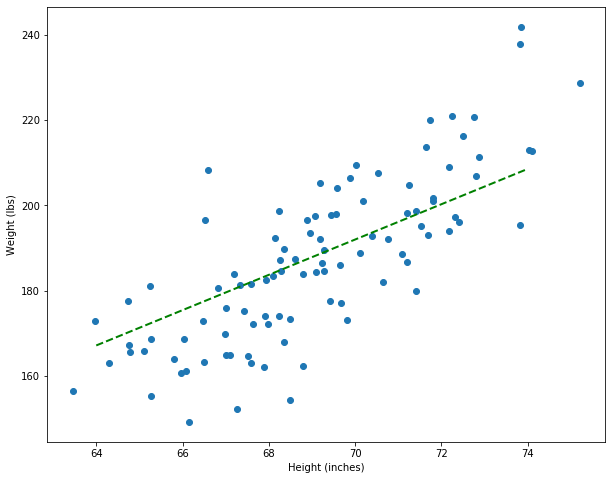

In [26]:
set_plot_1()

# Add the prediction line.
plt.plot([min_x, max_x], [pred_y_min, pred_y_max], color='green', linestyle='dashed', linewidth=2, markersize=12, label="bad model")

Wow! Even though we randomly guessed coefficients, this line looks pretty good -- that's the power of computers: they're really fast and can make a lot of guesses. But the line still doesn't look perfect. In fact, it can still be improved quite a bit. If random guessing feels inefficient and imperfect to you, then your intuitions are correct. There's a much better way to find the correct coefficients, but it involves calculus. In the next section I'll introduce a new dataset. That dataset will be useful when thinking about gradient descent, which is an algorithm that finds good coefficients (the section after).

## A New Dataset

The formula for drawing a line, _y = mx + b_ is often called a linear equation: line, linear, makes sense, right? But you've been lied to: equations that look like this are actually called _affine equations_ and allow a line to change its slope, _m_, and y-intercept, _b_. A linear equation is similar, but the line is fixed at the origin of the graph -- a true linear equation takes the form _y = mx_ -- it's lacking the y-intercept coefficient _b_.

An important difference between linear and affine equations are the number of parameters: affine equations have two, but linear equations only have one. If you used a linear equation to model your data, you'd have less flexibility, because the line is fixed to the origin: this means a linear equation is only good for modeling linear data where all the variables are zero at the same time. However, linear equations are simpler (because they only have one parameter), and for the upcoming examples, simplicity is important. So I'm going to introduce a new dataset that we can use linear equations to model.

In the cells below, I'm going to create a new dataset, create some linear models, and estimate their sum of squared errors.

In [27]:
class LinearModel(object):
    """
    This class is a linear model that accepts one parameter, m (slope).
    It also implements the predict method, which applies the linear equation to predict an output.
    """
    def __init__(self, m):
        self.m = m
    
    def predict(self, x):
        return x * self.m

In [28]:
import numpy as np

DATA_SIZE = 50

# Generate some random X-values.
X = [np.random.random() for _ in range(DATA_SIZE)]

# Create a linear model.
linear_model_1 = LinearModel(1.5)

# Create some y-values as a linear function of the X-values.
y = [linear_model_1.predict(x) for x in X]

# Add some noise to the y-values.
y = [i + np.random.normal(0, 0.2) for i in y]

# Read everything into a dataframe for later use.
df_2 = pd.DataFrame(list(zip(X, y)), columns=["X", "y"])

df_2.head(5)

,X,y
0,0.113087,0.176726
1,0.376516,0.532754
2,0.339732,0.368162
3,0.847044,1.415249
4,0.556842,1.090197


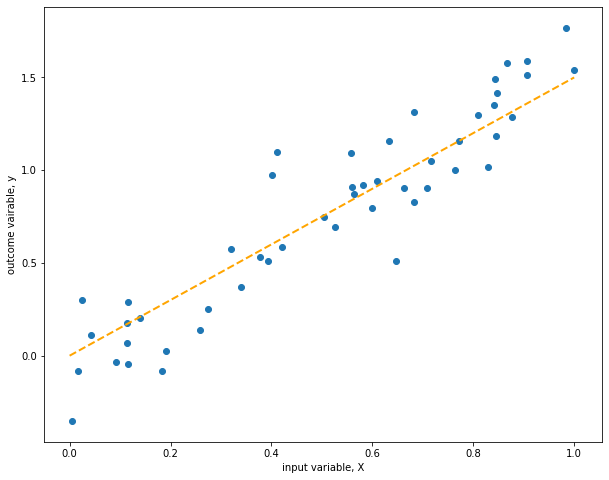

In [29]:
# Plot it!

X = df_2["X"]
y = df_2["y"]

def set_plot_2():
    plt.rcParams['figure.figsize'] = [10, 8]
    plt.xlabel("input variable, X")
    plt.ylabel("outcome vairable, y")
    plt.scatter(X, y)

set_plot_2()

plt.plot([0, 1], [0, 1.5], color='orange', linestyle='dashed', linewidth=2, markersize=12, label="model")

Cool! The line fits perfectly... which makes sense, because we generated the data using the model represented by the line, except that I added some random noise to make things interesting... Models can predict new output variables based on inputs, which measn we can use them to generate data!

For the rest of this section, we'll forget that we used the model to generate the data and will pretend that we want to find the best parameter to model the data. Because I used `1.5` when instantiating the `LinearModel` class, I'll expect the parameter of the model we try to create to be similar to this.

Now I'm going to generate a family of related linear functions. All of these functions will take the same form, `y = x * m`, except they'll have different values for _m_ and therefore different sums of squared errors.

In [30]:
# 1.5 is the coefficient used when the data was generated, so the SSE is low.
best_sse = sse(linear_model_1, X, y)
print(f"{best_sse:.2f}")

1.92


In [31]:
# A larger coefficient = higher SSE
linear_model_2 = LinearModel(1.9)
sse_2 = sse(linear_model_2, X, y)
print(f"{sse_2:.2f}")

4.07


In [32]:
# Likewise, a coefficient lower than 1.5 also gives a higher SSE
linear_model_3 = LinearModel(0.7)
sse_3 = sse(linear_model_3, X, y)
print(f"{sse_3:.2f}")

14.48


In fact, we can graph the errors produced by `get_sse` as the imput value, `m` changes. Let's do that!

In [33]:
coef_error = []

for i in range(-40, 60, 1):
    coef = i/10
    linear_func = LinearModel(coef)
    error = sse(linear_func, X, y)

    coef_error.append([coef, error])

df_errors = pd.DataFrame(coef_error, columns=["Coef", "Error"])

df_errors.head(5)

,Coef,Error
0,-4.0,542.302970
1,-3.9,522.993234
2,-3.8,504.034777
3,-3.7,485.427599
4,-3.6,467.171701


In [34]:
# What's the error associated with the coefficient of 1.5?
df_errors[df_errors["Coef"] == 1.5]

,Coef,Error
55,1.5,1.917192


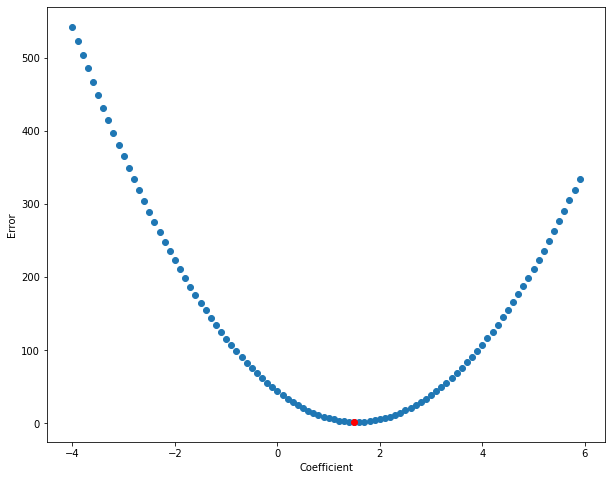

In [35]:
# Plot the error as a function of the coefficient value.
plt.rcParams['figure.figsize'] = [10, 8]
plt.xlabel("Coefficient")
plt.ylabel("Error")

plt.plot(1.5, best_sse, "ro")
plt.scatter(df_errors["Coef"], df_errors["Error"])

Cool! Notice how the error is lowest right around the coefficient-value of 1.5 and gets higher the further we move away from that value. Error, as a function of the coefficient, looks to be bowl-shaped -- and this bowl-shaped relationship is what lets us automatically find the area of lowest error. Also, it should now be clear why we switched from talking about affine equations (with two coefficients) to linear equations (with just one coefficient) -- it's easier to graph the relationship between one coefficient and the error than it is with two!

Now I'll plot the slope of the line at a few different points:

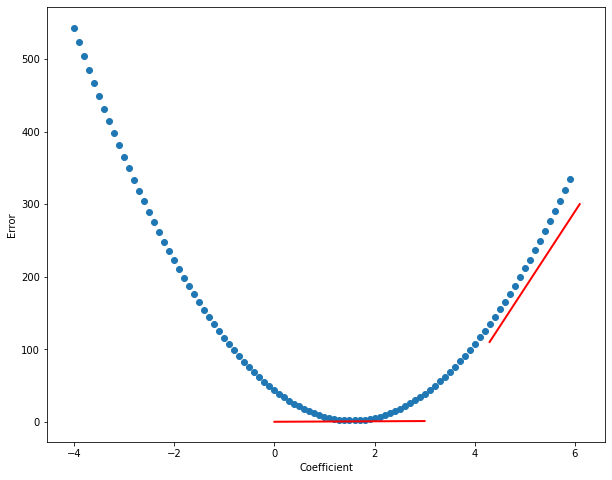

In [36]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.xlabel("Coefficient")
plt.ylabel("Error")

plt.plot([0, 3], [0, 1], color='red', linestyle='solid', linewidth=2, markersize=12, label="slope tangent to x=1.5")
plt.plot([4.3, 6.1], [110, 300], color='red', linestyle='solid', linewidth=2, markersize=12, label="slope tangent to x=1.5")

plt.scatter(df_errors["Coef"], df_errors["Error"])

Notice how at the bottom of the bowl (near coef = 1.5) the function is almost flat - this is represented by the horizontal red line, which shows the slope at the bottom of the bowl. And as you move away from 1.5, it's steeper - the red line on the right of the graph below shows a steeper slope. The slope of the function is close to zero at 1.5, and the slope rises as you move away from that value. Calculus lets us find the derivitive of a function, which is another way of saying slope. If we know the place in the function where the derivitive is zero, then we'll also know the coefficient value that minimizes the error! Cool, right? The graph below shows that the derivitive (slope of the line) is lower near the bottom of the bowl than near its edges.

Using the logic that we developed in the **Finding the Right Parameters** section, we can randomly guess coefficient values and then take the derivitive of the function at those points, and the coefficient values that have the lowest derivitive are probably the best... but wait... this line of reasoning doesn't simplify things: it just converts "minimize error" to "minimize derivitive"... there has to be a better way... and there is!

Once some value for the coefficient is discovered, you can find the slope of the line at that point, and then follow the slope downhill. Keep taking steps downhill until you flatten out, then stop -- you've found the bottom. But how do you actually know which way is downhill? In the next section I introduce gradient descent, which is an algorithm that lets us follow the slope of the function "downhill" to where the error is minimized, in the "bottom of the bowl."

In the next section, we'll find the derivitive of the error function. Knowing the derivitive is the key that lets us find the bottom of the bowl... but it'll take some calculus.

## Gradient Descent

Note: a "gradient" is just the multi-dimensional generalization of a derivative. In the case of linear regression, each parameter (_m_, _b_) represents a different dimension. However, because a linear equation has only one parameter, _m_, you can simple take the derivative, not the gradient. However, the algorithm is still called _gradient_ descent.

Let's take the derivitive of the error function. Remember that the sum of squared errors is: 

$$ SSE = \sum_{i=1}^n (\hat{y_i} - y_i)^2 $$

However, this doesn't actually include the coefficients that produced this error, so let's remind ourself of what y-hat actually equals:

$$ \hat{y} = mx $$

And then let's plug this into the formula for SSE. Also, we'll put _m_ in parentheses after _SSE_ to remind ourselves that we're going to take the SSE with respect to a model with the parameter _m_ that we want to optimize:

$$ SSE(m) = \sum_{i=1}^n (mx_i - y_i)^2 $$

I'm not going to walk through the entire process of generating the derivative of this function. However, it involves applying the [chain rule](https://en.wikipedia.org/wiki/Chain_rule) and understanding the the derivative of a sum is the same as the sum of derivatives. The resulting derivative is this:

$$ \frac{d}{dm} SSE(m) = 2\sum_{i=1}^n (mx_i - y_i)x_i$$

Now that we know the derivitive of this error function, we can think about how to apply this knowledge to updating our parameter, _m_. If we follow the slope of the function as it increases, we'll move away from the bottom of the bowl that we want to head towards. Instead, we can move against the slope by multiplying the derivative by _-1_ and then heading a small step in that direction. We only want to take a small step in that direction because large steps can make us overshoot the target. The step size is often called _alpha_ and _0.01_ is a good starting guess for _alpha_ (this can be re-guessed later if your parameter doesn't converge to a useful value).

In [37]:
def get_derivative(X, y, m):
    """
    This function finds the derivative of the linear function with a specific parameter, m.
    """
    return 2 * ( sum( (m * X - y) * X) )

In [38]:
# Implement gradient descent.

def gradient_descent(model, X, y, alpha=0.01, epochs=100):
    """
    This function implements gradient descent. It accepts a dataframe and a linear model.
    alpha is the learning rate.
    epochs is the number of times the function is run.
    """
    parameters = []
    m = -5 # random value
    for i in range(epochs):
        m = m - alpha * get_derivative(X, y, m)
        error = sse(LinearModel(m), X, y)
        parameters.append({"coef": m, "error": error})

    return parameters

params = gradient_descent(LinearModel, X, y)
best_derivative = params[-1]
best_derivative

{'coef': 1.5469758123178028, 'error': 1.878432776540043}

Now let's plot the value of the error for some of our coefficients. Notice that on every step, the value of the error decreases and the value of the coefficient moves towards 1.5, the bottom of the bowl!

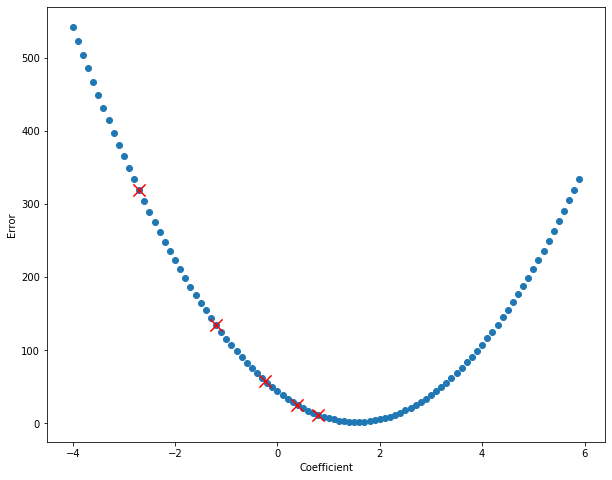

In [39]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.xlabel("Coefficient")
plt.ylabel("Error")

plt.scatter(df_errors["Coef"], df_errors["Error"])

# Plot the first few points generated by the gradient descent algorithm to show them improving.
for param in params[:5]:
    plt.scatter(param["coef"], param["error"], marker="x", color="red", s=150)

This is great! Now, instead of randomly guessing thousands of times, we can find the correct value for the coefficient in just a few steps. Now let's use the coefficient we discovered to plot the model.

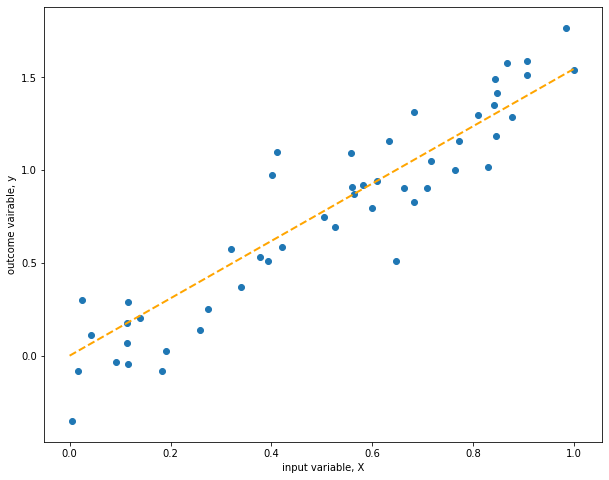

In [40]:
# Plot model using coefficient.
model = LinearModel(best_derivative["coef"])

# Plot it!
set_plot_2()

plt.plot([0, 1], [model.predict(0), model.predict(1)], color='orange', linestyle='dashed', linewidth=2, markersize=12, label="model")


This model looks great! Instead of optimizing the coefficient _m_ using random guessing, we used a much more efficient algorithm called gradient descent. Let's see if we can apply the same logic with affine equations.

## Back to Affine

In the section above, I showed you how to optimize the parameters for a linear equation. Linear equations are nice because they only have one parameter that needs to be tweaked: the slope of the line, _m_. In this section I'm going to show you how to optimize multiple parameters at the same time (in the case of an affine equation, this means 2 parameters, but the same logic will work for models with many more parameters), then teach you the math, and then return to our first dataset and find the correct parameters to get it to fit the data.

A _gradient_ is the multi-dimensional version of a derivitive. Imagine you're standing on a hill and you want to know the fastest way downhill. The gradient gives you coefficients of the two coordinates (North/South, East/West) that point uphill the fastest... going opposite the gradient points you the fastest way downhill. In the section above we used the gradient descent algorithm with only one variable... but in that case it's more accurate to have called it the derivitive descent algorithm! Gradient descent was originally designed for algorithms with multiple variables. So let's find the gradient for the affine function and use it to optimize our coefficients!

The error function we've used previously was the sum of squared errors. However, we're not restricted to using only this error function. In fact, for this application a different error function is commonly used, called Mean Squared Error. It's very similar to SSE, as you'll see below. Also, in the field of deep learning, error functions are usually called _loss functions_:

$$ MSE = \frac{1}{n} \sum_{i=1}^n (\hat{y_i} - y_i)^2 $$

However, when you expand it to include the specific function that generates y-hat, in this case the affine function, things begin to look different:

$$ MSE(m, b) = \frac{1}{n} \sum_{i=1}^n (mx_i + b - y_i)^2 $$

The gradient of this function is a little messy, and like the derivative done in the last section, involves the chain rule. So I'll skip a few steps. But the overall idea is that we have to take independent derivitives for each of the variables _m_ and _b_ that contribute to the function. The backwards d symbol means "derivative with respect to" and the two parameters we're taking derivatives with respect to are _m_ and _b_:

$$ \frac{\partial}{\partial m} \frac{1}{n} \sum_{i=1}^n (mx_i + b - y_i)^2 = \frac{1}{n} \sum_{i=1}^n (mx_i + b - y_i)x_i $$

$$ \frac{\partial}{\partial b} \frac{1}{n} \sum_{i=1}^n (mx_i + b - y_i)^2 = \frac{1}{n} \sum_{i=1}^n (mx_i + b - y_i)(-1) $$

In [41]:
# Re-define the gradient function to accept a dataframe and a model.

X = df_1["Height"]
y = df_1["Weight"]

def get_affine_gradient(model, X, y):
    """
    This function finds the gradient of an affine function with parameters
    m, b and returns a tuple (derivative_m, derivative_b).
    """
    y_pred = [model.predict(x) for x in X]
    
    n = len(y_pred)
    
    # Note: the gradient is divided by `n` to get the "average gradient."
    deriv_m = (-1/n) * sum((y - y_pred) * X)
    deriv_b = (-1/n) * sum(y - y_pred)

    return deriv_m, deriv_b


# Example gradient
model = SimpleLinearRegression(3.5, -50)
get_affine_gradient(model, X, y)

(295.38049274948446, 4.571590013567771)

In [42]:
# Define the gradient descent function for the two-variable affine function.
# Use a small default alpha and a small number of epochs.

def gradient_descent_affine(model, X, y, alpha=0.0001, epochs=5000):
    """
    This function accepts a dataframe and two parameters: m and b which are to
    be optimized under the affine model. Other parameters include:
    alpha: the learning rate
    epochs: the number of times to update the parameters.
    """
    parameters = []
    m, b = random.random(), random.random()
    
    for i in range(epochs): 
        m_partial, b_partial = get_affine_gradient(model(m, b), X, y)

        m = m - alpha * m_partial
        b = b - alpha * b_partial
        
        error = sse(model(m, b), X, y)
        parameters.append({"m": m, "b": b, "error": error})

    return parameters

In [43]:
points = gradient_descent_affine(SimpleLinearRegression, X, y)
best_coefs = points[-1]
best_coefs

{'m': 2.708642367492207, 'b': 0.439179409505377, 'error': 933818.8063329143}

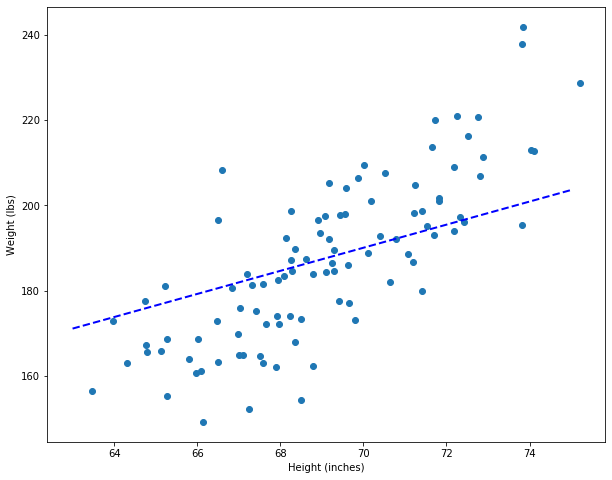

In [44]:
set_plot_1()

# Create a model using the coefficients optimized using gradient descent.
model = SimpleLinearRegression(best_coefs["m"], best_coefs["b"])

# Add a prediction line.
plt.plot([63, 75], [model.predict(63), model.predict(75)], color='blue', linestyle='dashed', linewidth=2, markersize=12, label="good model")


Notice that this model is good but not great -- definitely not as perfect as the model created using the simple, linear model. One way we can address this is with additional optimization: try again with more training epochs, start off with different initial parameter guesses, etc. But another, simpler way is to put our data science hats on and rescale our variable values. If we min-max scale our X and y variables so that they are all between 0 and 1, it will speed up learning. We can always un-convert the scale of our variables later. Let's give it a try.

In [45]:
# Min-max scale the variables to the interval [0, 1]
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df_1[["Height", "Weight"]])

scaled_data = scaler.transform(df_1[["Height", "Weight"]])

In [46]:
df_1_scaled = pd.DataFrame(scaled_data, columns=["Height", "Weight"])

In [47]:
# Run gradient descent using the new, scaled dataset. Increase the learning rate and drop the epochs.
X = df_1_scaled["Height"]
y = df_1_scaled["Weight"]

points = gradient_descent_affine(SimpleLinearRegression, X, y, alpha=0.1, epochs=5000)
best_coefs = points[-1]
best_coefs

{'m': 0.7811644506614087, 'b': 0.06897386314587933, 'error': 20.23499141371434}

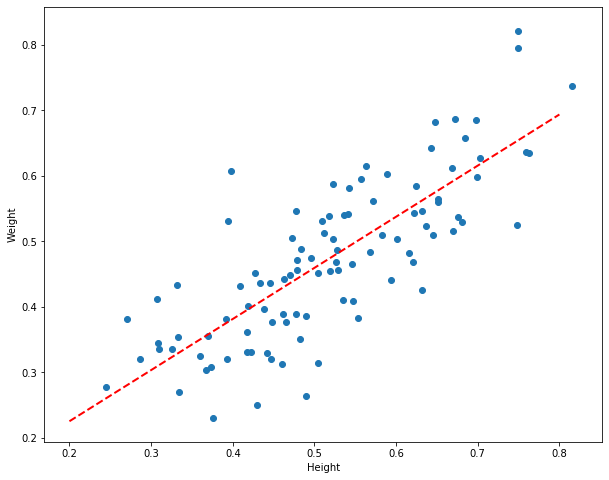

In [48]:
def set_plot_3():
    plt.rcParams['figure.figsize'] = [10, 8]
    plt.xlabel("Height")
    plt.ylabel("Weight")
    plt.scatter(X[:100], y[:100])

set_plot_3()

# Create a model using the coefficients optimized using gradient descent.
model = SimpleLinearRegression(best_coefs["m"], best_coefs["b"])

# Plot it!
plt.plot([0.2, 0.8], [model.predict(0.2), model.predict(0.8)], color="red", linestyle='dashed', linewidth=2, markersize=12)

Models created using coefficients from earlier in the training process should be worse, and models created later should be better. Let's plot them and see if that's true. 

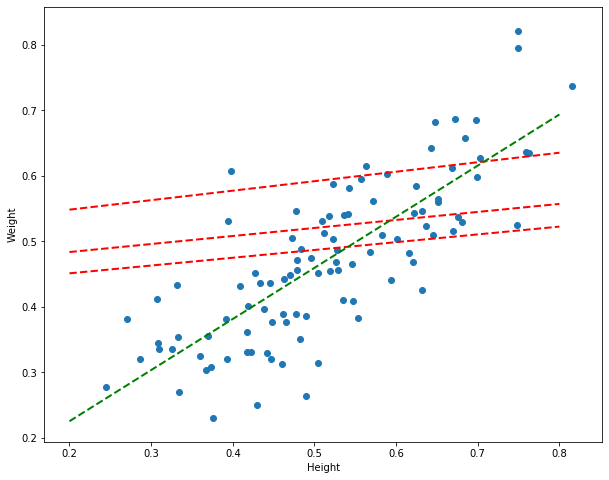

In [49]:
set_plot_3()

# Create several models using the coefficients from different points in time.
model_1 = SimpleLinearRegression(points[3]["m"], points[3]["b"])
model_2 = SimpleLinearRegression(points[10]["m"], points[10]["b"])
model_3 = SimpleLinearRegression(points[20]["m"], points[20]["b"])
model_4 = SimpleLinearRegression(best_coefs["m"], best_coefs["b"])

# Iterate over all the models, plotting them.
for model, color in [(model_1, "red"), (model_2, "red"), (model_3, "red"), (model_4, "green")]:
    plt.plot([0.2, 0.8], [model.predict(0.2), model.predict(0.8)], color=color, linestyle='dashed', linewidth=2, markersize=12, label="good model")

Awesome! Notice how the earlier models (the red lines) are worse than the final model (the green line). Over time, the models actually approach the optimum, getting better and better with each trainng step -- on every step, the gradient is found, the coefficients are updated, the error decreases, and the model improves.

Finding a model, finding an error function, and finding an optimization technique (linear regression, MSE, gradient descent) is the core process by which machine learning works. Keep in mind that each of these pieces can be substitued: a neural network can be used instead of an affine model, stochastic gradient descent can be used instead of the vanilla flavor, etc.

In the next few sections I'm going to wrap up a few loose ends by dealing with these questions:
- How do we use multiple input values (like weight and age) instead of just one to predict a single value (like blood pressure)?
- How do we deal with more complicated linear models (like polynomial models)?
- How do we use categorical variables like eye color or gender?

In order to answer these questions, I'm going to have to introduce a little linear algebra -- but if you've been able to follow along so far, it won't be too hard. I'll also introduce a little but more math when talking about more complicated linear models (with several variables).

## Multiple Linear Regression
The first two data sets we've explored -- height vs weight and the dummy dataset we created -- both had a single input variable and a single outcome variable. But what if you have multiple variables that you care about? For instance, let's say that you're trying to predict a person's blood pressure given their age and weight? Well, there's [a dataset](https://college.cengage.com/mathematics/brase/understandable_statistics/7e/students/datasets/mlr/frames/frame.html) with that exact information!

In this section I'll introduce this new dataset, describe a new way to think about our model (using linear algebra), and then actually build a model using the open source library Scikit Learn instead of the custom-built tools I created.

In [50]:
# Create a new dataframe.
df_3 = pd.read_excel("../data/mlr02.xls")
df_3.columns = ["bp", "age", "weight"]

*** No CODEPAGE record, no encoding_override: will use 'ascii'


In [51]:
df_3.head(5)

,bp,age,weight
0,132,52,173
1,143,59,184
2,153,67,194
3,162,73,211
4,154,64,196


In [52]:
# Import the data visualization library Seaborn
import seaborn as sns

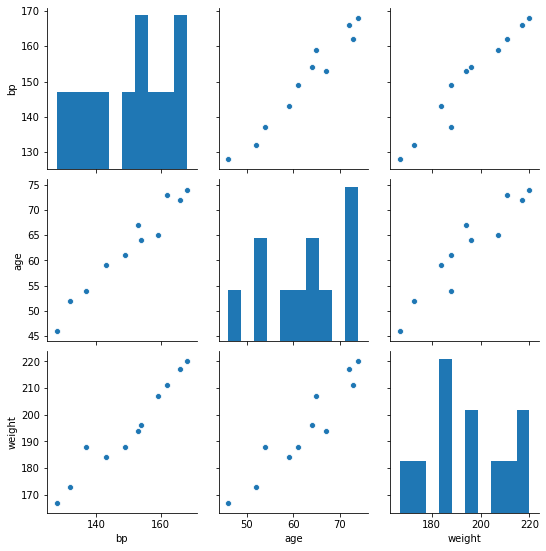

In [53]:
# Plot the relationships between all of the variables.
sns.pairplot(df_3)

Great! It looks like the relationships between all the variables are linear -- that means a linear model is probably appropriate for solving our problem. But before we continue, let's change the names of the variables to conform with the usual mathematical notation: the input variables are _X_ and the outcome variable is _y_. We can always convert these back to the actual variable names later.

In [54]:
df_3.columns = ["y", "x1", "x2"]
df_3.head(3)

,y,x1,x2
0,132,52,173
1,143,59,184
2,153,67,194


In the previous sections we talked about the paramaters of our model, _m_ and _b_. But because some models will have lots of parameters, it's easier to use the Greek letter beta for each parameter:

$$ \hat{y} = \beta_0 + \beta_1x_1 + \beta_2x_2 $$

In a regression model with two input variables, there are three parameters: beta_0, beta_1, and beta_2. Notice that this is extremely similar to the familiar _y = mx + b_, except that the _m_ and _b_ are replaced by betas, and there's one extra _x_ and it has its own _beta_. For a regression model made using a dataset with _p_ input variables, there will always be _p + 1_ parameters.

Another mathematical simplification is to think of each variable as a vector of data. For instance, the output variable, _y_ is:

$$ \boldsymbol{y} = \begin{bmatrix}
     y_1 \\  
     y_2 \\
     \vdots \\
     y_n
     \end{bmatrix}
$$

And the parameters are another vector:

$$ \boldsymbol{\beta} = \begin{bmatrix}
     \beta_1 \\  
     \beta_2 \\
     \vdots \\
     \beta_n
     \end{bmatrix}
$$

The input variables are also vectors, where the number of variables is denoted as _k_:

$$ X_1, X_2,  \cdots,  X_k$$

And each, individually, looks like this:

$$ X_1 = 
\begin{bmatrix}
     x_1 \\  
     x_2 \\
     \vdots \\
     x_n
     \end{bmatrix}
$$

You can then package all of these input vectors into a matrix, that looks like this (the reason why the first column is only 1's will be explained shortly):

$$
X = \begin{bmatrix}
     1 & x_{1,1} & ... & x_{1,k} \\    
     1 & x_{2,1} & ... & x_{2,k} \\
     \vdots & \vdots & \ddots & \vdots \\
     1 & x_{n,1} & ... & x_{n,k}
     \end{bmatrix}
$$

Then, using linear algebra notation, we can describe our regression model as a vector of predictions, _y_ being produced by the multiplication of a vector of data, _X_, with vector of parameters, _beta_:

$$ y = X\beta $$

Even though this looks extremely simplified, when you perform [matrix vector multiplication](https://mathinsight.org/matrix_vector_multiplication) you get an equation identical to the first equation introduced in this section. The reason why the first column of the _X_ matrix are all _1's_ is because when the _X_ is multiplied by the parameter vector, this let's us have a single parameter (the y-intercept) that's not multiplied by any of our data points.

Tasks like multiplying vectors by matrixes falls under the field of [linear algebra](https://en.wikipedia.org/wiki/Linear_algebra). This field of mathematics lets us simplify much of the work we do in the machine learning, so it's essential to be familiar with the basics of linear algebra. Try multiplying the _X_ matrix by the coefficient matrix and see that it yields an expanded linear equation that's very familiar to you!

Now that we've gotten the math out of the way, let's actually build a model. Instead of starting from scratch, let's use Scikit-Learn instead. This library has many of the same functions we've already built ourselves:

In [55]:
# Import the sklearn package.
from sklearn.linear_model import LinearRegression

In Sklearn, when we call `fit` on the linear regression model, we're using an optimization technique to find the best coefficient values. However, unlike previously, the technique used here isn't gradient descent. Instead, Sklearn uses a different optimization technique (called [Ordinary Least Squares](https://en.wikipedia.org/wiki/Linear_least_squares#Derivation_of_the_normal_equations) (OLS)) which happens to only work for this specific optimization problem. Gradient descent is applicable to a much wider range of optimization problems in ML, which is why I've described it here. Additionally, OLS uses some pretty tricky math, like the [Moore-Penrose pseudo-inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse), so I've decided to skip it.

If you want to use a linear regression model with a gradient descent optimizer, you can try Sklearn's [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html).

In [56]:
# Fit the linear regression model.
reg = LinearRegression().fit(df_3[["x1", "x2"]], df_3["y"])

In [57]:
# Show the coefficients generated by the model.
reg.coef_, reg.intercept_

(array([0.86141469, 0.3348592 ]), 30.994102952348328)

In [58]:
# Predict some random data point.
point = 2
X = df_3[["x1", "x2"]]
y = df_3["y"]
pred = reg.predict(X[point:point+1])[0]
actual = y[point]

print(f"The predicted blood pressure was {pred:.2f} and the actual was {actual} -- these numbers are really close!")

The predicted blood pressure was 153.67 and the actual was 153 -- these numbers are really close!


It seems like our model is doing good -- the predicted values look like they're close to the actual values. However, how do we demonstrate, mathematically, how good a model is? In previous sections we looked at the sum of squared errors and mean squared error: but these measures only tell us how good one model is when compared to another model. What we ideally want is some kind of objective measurement that tells us how linear the data is in the first place. Consider the two datasets below, which have been fitted using linear regression models:

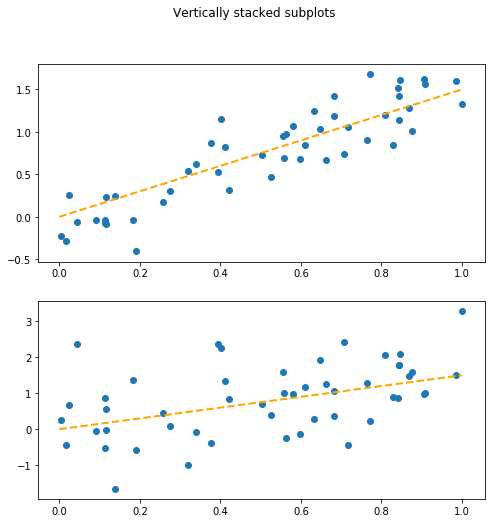

In [59]:
X = df_2["X"]
y = df_2["y"]

y1 = [i + np.random.normal(0, 0.2) for i in y]
y2 = [i + np.random.normal(0, 0.8) for i in y]

plt.rcParams['figure.figsize'] = [8, 8]
fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].scatter(X, y1)
axs[0].plot([0, 1], [0, 1.5], color='orange', linestyle='dashed', linewidth=2, markersize=12, label="model")
axs[1].scatter(X, y2)
axs[1].plot([0, 1], [0, 1.5], color='orange', linestyle='dashed', linewidth=2, markersize=12, label="model")

In the dataset on the top, the observations are strongly linear -- they hug the line closely. Whereas in the dataset on the bottom, the observations are less linear. In other words, in the first dataset, more of the variation in the outcome variable, _y_, can be explained by the input variable, _x_. Whereas in the second dataset _x_ predicts _y_ more weakly.

The coefficient of determination, R-squared, tells us how much of the variation in _y_ is caused by _x_. It's useful for telling us how good a model is __in general__, in contrast to telling us how good one model is compared to another. R-squared ranges from _-1_ to _1_ (where negative values represent a negative relationship between variables: i.e. as my height goes up, my weight goes down). Values close to 0 mean that there is no relationship between the variables. R-squared will be closer to 1 for the dataset on the left and closer to 0 for the dataset on the right.

R-squared is defined as:

$$ R^2 = 1 - \frac{SS_{res}}{SS_{tot}} $$

The Sum of Squares of the residuals (also known as the sum of squared errors) of the regression model measures the amount of variation left over after the regression model is considered. It's already familiar to you, but I'll remind you of the definition:

$$ SS_{res} = \sum_{i=1}^2 (\hat{y_i} - y_i)^2 $$

The total sum of squares measures the difference between a really bad model (just the mean, y-bar) and all of the data points:

$$ SS_{tot} = \sum_{i=1}^2 (y_i - \bar{y})^2 $$

In the R-squared formula above, when the unexplained errors are low, the fraction approaches 0. This means that R-squared will be larger. When the the fraction of unexplained errors are high, the fraction approaches 1, so R-squared is low. We can easily find this with the Sklearn library:

In [60]:
# Show the R-squared value for the model
r2 = reg.score(df_3[["x1", "x2"]], df_3["y"])

print(f"The R-squared for this model is {r2:.2f}, which means the data is strongly linear!")

The R-squared for this model is 0.98, which means the data is strongly linear!


In this section we learned the _standard approach_ to solving the data science problem of creating a linear model: import a useful package (Sklearn), do some analysis, and party. However, if you __only__ use a library there's a strong possibility that you'll be doing work and not understand what's going on under the hood -- which is something that __will__ come back to bite you.

## Wrapping Things Up

In this notebook I showed you how to build and understand linear models. But there are few loose ends to wrap up. The first of these has to do with the vague way I've been using the phrase __linear model__. I've been using this to refer to linear equations, affine equations, and linear regression models with one (or more) input variables that make use of these types of equations. But a linear model can also mean something else: a model that is _linear in its coefficients_. But what does that exactly mean?

### Complexity...

A model like multiple linear regression is linear in its coefficients because when we add another feature, _x_, to the model, the number of coefficients in the model goes up by one. To make it explicit, when there are two input features:

$$ y = \beta_0 + \beta_1x_1 + \beta_2x_2 $$

The regression equation is longer than when there is only one:

$$ y = \beta_0 + \beta_1x_1 $$

However, when we define linear regression loosely in this way, it also allows us to include polynomial models, such as the model below, where there is a single input variable:

$$ y = \beta_0 + \beta x + \beta x^2 + \beta x^3 + \beta x^4 + \beta x^5$$

These models are flexible and can fit even non-linear data. However, there is a consequence to all of this flexibility: your model can overfit the data. When a model overfits the data, it begins to make predictions that are specific to the data that was used to train it, and don't generalize to new data. This is why data scientists usually split their data into a training and a test set. When building models, data scientists use the training set. When the model is built, it's evaluated on the test set -- this ensures that the model can't "cheat" by overfitting itself to the test set. To learn more about this, see my post about [penalizing complexity](https://camtsmith.com/articles/2019-08/regularization).

### Different Types of Variables

The last issue I'll deal with are different types of variables. All the data we've dealt with so far has been continuous and numeric: all natural numbers (or floats if you want to think in computer science terms). But sometimes data comes in other forms: what if we want to return to the original dataset and predict _gender_ as a function of _height_? Let's try that out and see what happens:

In [61]:
df_4 = pd.read_csv("../data/weight-height.csv")
df_4.head(5)

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [62]:
# Dummy code the Gender column so that it's 0 or 1.
df_4 = pd.get_dummies(df_4)

# Drop the unnecessary column.
df_4 = df_4.drop(["Gender_Male"], axis=1)

df_4.head()

,Height,Weight,Gender_Female
0,73.847017,241.893563,0
1,68.781904,162.310473,0
2,74.110105,212.740856,0
3,71.730978,220.042470,0
4,69.881796,206.349801,0


In [63]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(pd.DataFrame(df_4["Height"]), df_4["Gender_Female"])
reg.coef_, reg.intercept_

(array([0.86141469, 0.3348592 ]), 30.994102952348328)

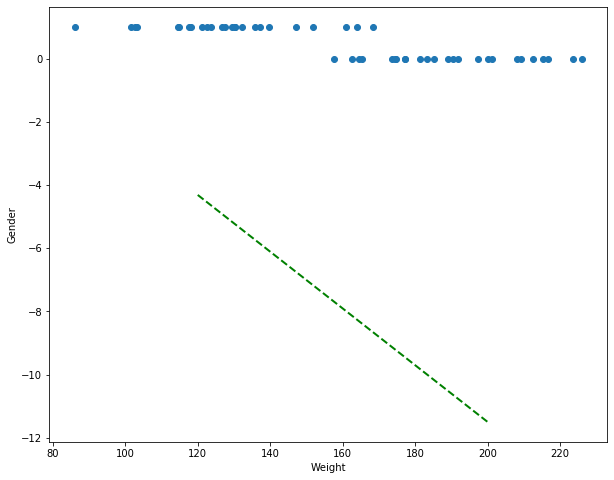

In [64]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.xlabel("Weight")
plt.ylabel("Gender")

# Sample 50 rows randomly.
df_4_sample = df_4.sample(50)

plt.scatter(df_4_sample["Weight"], df_4_sample["Gender_Female"])

plt.plot([120, 200], [model.predict([[120]]), model.predict([[200]])], color=color, linestyle='dashed', linewidth=2, markersize=12)

Ok. This looks really bad. We're trying to predict the gender from the weight... but the predictions (which should be either _0_ for male of _1_ for female) are negative numbers, nowhere near the data... I'm not even going to go into all the problems here, except to suggest using __a different model__ like [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression). Linear regression is useful for linear data... but the outcome variable here (gender) is binary... this algorithm just won't work. You should try implementing logistic regression yourself!

### Footnote

I hope this notebook has helped you understand linear regression better. Not only that, but the tools and tricks you learned here -- the calculus, linear algebra, and optimization to name just a few -- will be useful in other data science tasks.